### References:
- Article: https://analyticsindiamag.com/a-beginners-guide-to-time-series-modelling-using-pycaret/
- Code: https://colab.research.google.com/drive/1eQslDiNAHNj_7i5aayUF1RFjVdXeuuKl?usp=sharing

In [2]:
# !pip install pycaret[full]

In [54]:
import time
import numpy as np
import pandas as pd
import seaborn as sns

from pycaret.regression import *

In [4]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])

ID = 'row_id'
TARGET = 'num_sold'

dfs_dict = {"train":train_df, "test":test_df}
test_ids = test_df['row_id']

In [5]:
baseline_pred = []
num_sold_mean = int(train_df[TARGET].mean())
for id in test_ids:
    baseline_pred.append((id, num_sold_mean))

In [6]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [7]:
# Not sure if this is strictly necessary but seems logical to separate the data for each of the country / store / combo => 18 series
data_repo = {}
train_df['key'] = train_df['country'] + '_' + train_df['store'] + '_' + train_df['product']
for key in train_df['key'].unique():
    data_repo[key] = train_df[train_df['key'] == key].copy()

In [73]:
# Use one series for some tests first. 
data = data_repo['Finland_KaggleMart_Kaggle Mug']

#Drop unneeded columns:
data = data.drop(['country', 'store', 'product', 'key', 'row_id'], axis=1)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')
data.head()

,date,num_sold
0,2015-01-01,329
18,2015-01-02,318
36,2015-01-03,360
54,2015-01-04,332
72,2015-01-05,243


In [74]:
data['month'] = [i.month for i in data['date']]
data['year'] = [i.year for i in data['date']]
data['day_of_week'] = [i.dayofweek for i in data['date']]
data['day_of_year'] = [i.dayofyear for i in data['date']]
data['MA12'] = data['num_sold'].rolling(12).mean()

In [75]:
data.head(2000)

,date,num_sold,month,year,day_of_week,day_of_year,MA12
0,2015-01-01,329,1,2015,3,1,NaN
18,2015-01-02,318,1,2015,4,2,NaN
36,2015-01-03,360,1,2015,5,3,NaN
54,2015-01-04,332,1,2015,6,4,NaN
72,2015-01-05,243,1,2015,0,5,NaN
...,...,...,...,...,...,...,...
26208,2018-12-27,414,12,2018,3,361,270.000000
26226,2018-12-28,499,12,2018,4,362,290.250000
26244,2018-12-29,774,12,2018,5,363,336.666667
26262,2018-12-30,757,12,2018,6,364,380.166667


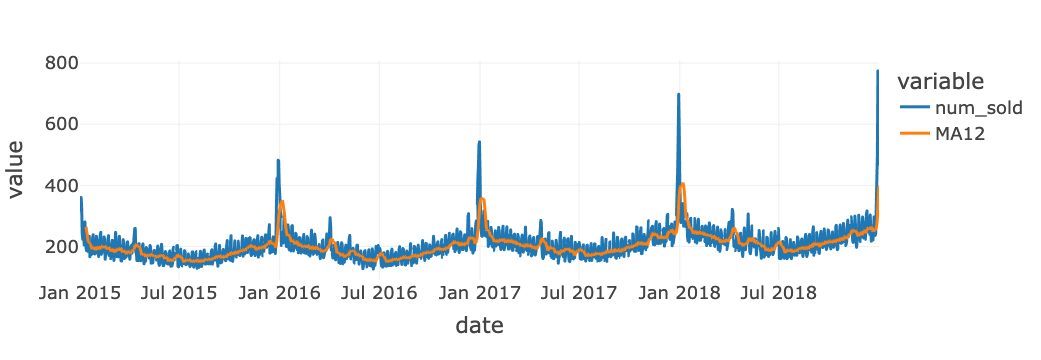

In [76]:
import plotly.express as px
fig = px.line(data, x="date", y=["num_sold","MA12"],template='presentation')
fig.show()

In [81]:
#Drop the date and ma12, not necessary
data = data.drop('MA12', axis=1)
train = data[data['year'] < 2018]
test = data[data['year'] >= 2018]

In [82]:
from pycaret.regression import *
# initialize setup
Setup_ = setup(data = train, test_data = test, target = 'num_sold', fold_strategy = 'timeseries', numeric_features = ['year','month','day_of_week','day_of_year'], fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,num_sold
2,Original Data,"(1096, 6)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1096, 24)"


In [83]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,20.7144,1246.0410,34.4596,0.5305,0.1368,0.0922,0.1767
dt,Decision Tree Regressor,21.7749,1306.3637,35.6927,0.5063,0.1464,0.0982,0.0133
et,Extra Trees Regressor,21.8758,1445.6827,37.4089,0.4541,0.1452,0.0968,0.1600
lightgbm,Light Gradient Boosting Machine,22.3718,1786.3088,42.0596,0.3429,0.1551,0.0960,0.0333
lr,Linear Regression,22.3798,2026.7701,44.4750,0.2378,0.1682,0.0948,0.0167
catboost,CatBoost Regressor,22.4122,1681.5430,40.5809,0.3857,0.1501,0.0975,0.9100
ridge,Ridge Regression,22.4161,2004.5781,44.2713,0.2473,0.1663,0.0950,0.0133
lar,Least Angle Regression,22.5966,2061.5422,44.7947,0.2230,0.1707,0.0958,0.0133
br,Bayesian Ridge,22.7104,2029.9302,44.5064,0.2364,0.1681,0.0965,0.0133
xgboost,Extreme Gradient Boosting,23.8167,1867.8665,42.6919,0.3019,0.1552,0.1067,0.0533


In [84]:
prediction_holdout = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,22.5386,1042.3431,32.2853,0.7005,0.1227,0.0920


In [85]:
# generate predictions on the original dataset
predictions = predict_model(best, data=data)

In [86]:
predictions.tail()

,date,num_sold,month,year,day_of_week,day_of_year,Label
26208,2018-12-27,414,12,2018,3,361,339.039039
26226,2018-12-28,499,12,2018,4,362,455.484661
26244,2018-12-29,774,12,2018,5,363,540.167891
26262,2018-12-30,757,12,2018,6,364,521.229195
26280,2018-12-31,469,12,2018,0,365,383.962725


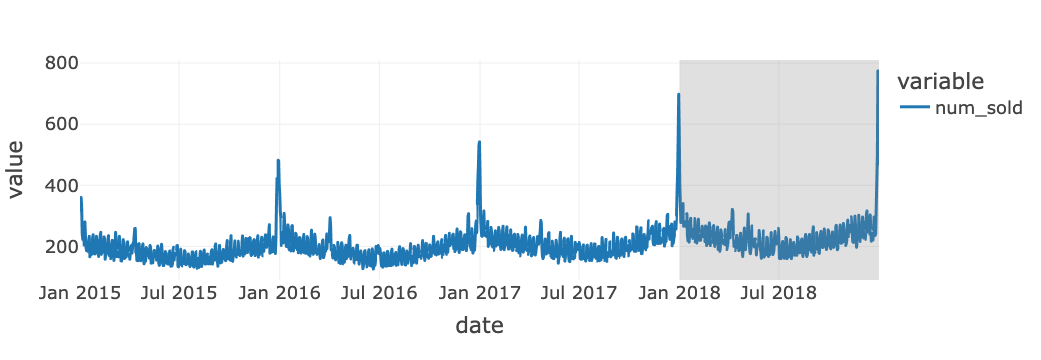

In [87]:
# add a date column in the dataset
predictions['date'] = pd.date_range(start='2015-01-01', end = '2018-12-31', freq = 'D')
# line plot
fig = px.line(predictions, x='date', y=['num_sold'], template = 'presentation')
# add a vertical rectange for test-set separation
fig.add_vrect(x0="2018-01-01", x1="2018-12-31", fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

In [88]:
final_best = finalize_model(best)

In [89]:
future_dates = pd.date_range(start = '2019-01-01', end = '2019-12-31', freq = 'D')
future_df = pd.DataFrame()
future_df['month'] = [i.month for i in future_dates]
future_df['year'] = [i.year for i in future_dates] 
future_df['day_of_week'] = [i.dayofweek for i in future_dates]
future_df['day_of_year'] = [i.dayofyear for i in future_dates]
future_df['date'] = future_dates


In [90]:
future_df.head()

,month,year,day_of_week,day_of_year,date
0,1,2019,1,1,2019-01-01
1,1,2019,2,2,2019-01-02
2,1,2019,3,3,2019-01-03
3,1,2019,4,4,2019-01-04
4,1,2019,5,5,2019-01-05


In [91]:
final_best = finalize_model(best)
predictions_future = predict_model(final_best, data=future_df)
predictions_future.head()

,month,year,day_of_week,day_of_year,date,Label
0,1,2019,1,1,2019-01-01,312.363387
1,1,2019,2,2,2019-01-02,301.430170
2,1,2019,3,3,2019-01-03,267.339403
3,1,2019,4,4,2019-01-04,236.468630
4,1,2019,5,5,2019-01-05,311.799491


In [93]:
predictions_future.head()

,month,year,day_of_week,day_of_year,date,Label
0,1,2019,1,1,2019-01-01,312.363387
1,1,2019,2,2,2019-01-02,301.430170
2,1,2019,3,3,2019-01-03,267.339403
3,1,2019,4,4,2019-01-04,236.468630
4,1,2019,5,5,2019-01-05,311.799491


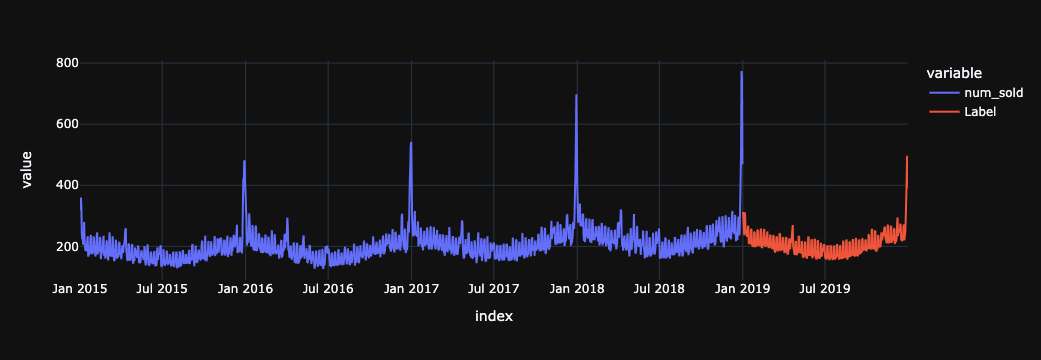

In [92]:
concat_df = pd.concat([data,predictions_future], axis=0)
concat_df_i = pd.date_range(start='2015-01-01', end = '2019-12-31', freq = 'D')
concat_df.set_index(concat_df_i, inplace=True)
fig = px.line(concat_df, x=concat_df.index, y=["num_sold", "Label"], template = 'plotly_dark')
fig.show()